# U.S. Counties

This notebook contains scripts that generate a dataset of U.S. counties, based on the data from the U.S. Census Bureau. The generated dataset has the following structure:

* `state_fips` - FIPS code of the U.S. state.
* `state_abbr` - two-symbol USPS state abbreviation.
* `fips_code` - FIPS code of the county.
* `name` - a name of the county.
* `lsad_code` - LSAD type of the county.
* `name_lsad` - a name of the county with its LSAD type.
* `geometry` - a geographical shape of the county (not included in CSV).

The script generates the dataset in CSV and Shape formats. Result files are stored in the output directory, specified by the `OUTBOUND_PATH` constant.

In [1]:
'''
Notebook parameters.
'''

DOWNLOAD = False
GEODATA_YEAR = "2021"
GEODATA_BASE_URI = "https://www2.census.gov/geo/tiger"

INBOUND_PATH = "../data/inbound/geo"
OUTBOUND_PATH = "../data/outbound/geo"

In [2]:
'''
Define U.S. regions.
'''

NEW_ENGLAND         = ["CT", "ME", "MA", "NH", "RI", "VT"]
MIDDLE_ATLANTIC     = ["NJ", "NY", "PA"]
EAST_NORTH_CENTRAL  = ["IN", "IL", "MI", "OH", "WI"]
WEST_NORTH_CENTRAL  = ["IA", "KS", "MN", "MO", "NE", "ND", "SD"]
SOUTH_ATLANTIC      = ["DE", "DC", "FL", "GA", "MD", "NC", "SC", "VA", "WV"]
EAST_SOUTH_CENTRAL  = ["AL", "KY", "MS", "TN"]
WEST_SOUTH_CENTRAL  = ["AR", "LA", "OK", "TX"]
MOUNTAIN            = ["AZ", "CO", "ID", "NM", "MT", "UT", "NV", "WY"]
PACIFIC             = ["CA", "OR", "WA"]
OCEAN               = ["AK", "HI"]

NORTHEAST           = NEW_ENGLAND + MIDDLE_ATLANTIC
MIDWEST             = EAST_NORTH_CENTRAL + WEST_NORTH_CENTRAL
SOUTH               = SOUTH_ATLANTIC + EAST_SOUTH_CENTRAL + WEST_SOUTH_CENTRAL
WEST                = MOUNTAIN + PACIFIC
CONTINENTAL         = NORTHEAST + MIDWEST + SOUTH + WEST

In [3]:
'''
Import dependencies.
'''

import os
import wget

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [4]:
'''
Initialize states dataframe.
'''

# load dataframe
states = gpd.read_file(OUTBOUND_PATH + "/us_states.shp.zip", compression="zip")

# normalize column types
states.fips_code = states.fips_code.astype("string")
states.usps_abbr = states.usps_abbr.astype("string")
states.name = states.name.astype("string")

states.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   fips_code  56 non-null     string  
 1   usps_abbr  56 non-null     string  
 2   name       56 non-null     string  
 3   geometry   56 non-null     geometry
dtypes: geometry(1), string(3)
memory usage: 1.9 KB


In [5]:
'''
Download and initialize counties dataframe.
'''

filename = "tl_" + GEODATA_YEAR + "_us_county.zip"

if DOWNLOAD:
    # download dataset
    source = GEODATA_BASE_URI + "/TIGER" + GEODATA_YEAR + "/COUNTY/" + filename
    dest = INBOUND_PATH + "/" + filename
    if os.path.exists(dest):
        os.remove(dest)
    wget.download(source, dest)

# create dataframe
counties = gpd.read_file(INBOUND_PATH + "/" + filename, compression="zip")

# drop unnecessary columns
counties.drop(
    [
        "COUNTYNS", "GEOID", "CLASSFP", 
        "MTFCC", "CSAFP", "CBSAFP", "METDIVFP", "FUNCSTAT", 
        "ALAND", "AWATER", "INTPTLAT", "INTPTLON"
    ],
    axis=1,
    inplace=True,
)

# rename columns
counties.rename(
    columns={
        "STATEFP": "state_fips",
        "COUNTYFP": "fips_code",
        "NAME": "name",
        "LSAD": "lsad_code",
        "NAMELSAD": "name_lsad",
    },
    inplace=True
)

# normalize column types
counties.state_fips = counties.state_fips.astype("string")
counties.fips_code = counties.fips_code.astype("string")
counties.name = counties.name.astype("string")
counties.lsad_code = counties.lsad_code.astype("string")
counties.name_lsad = counties.name_lsad.astype("string")

counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3234 entries, 0 to 3233
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   state_fips  3234 non-null   string  
 1   fips_code   3234 non-null   string  
 2   name        3234 non-null   string  
 3   name_lsad   3234 non-null   string  
 4   lsad_code   3234 non-null   string  
 5   geometry    3234 non-null   geometry
dtypes: geometry(1), string(5)
memory usage: 151.7 KB


In [6]:
'''
Merge counties and states.
'''

counties = pd.merge(
    counties, 
    states.drop(["name", "geometry"], axis=1).rename(columns={
        "fips_code": "state_fips",
        "usps_abbr": "state_abbr",
    }), 
    on="state_fips",
    how="left"
)

counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3234 entries, 0 to 3233
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   state_fips  3234 non-null   string  
 1   fips_code   3234 non-null   string  
 2   name        3234 non-null   string  
 3   name_lsad   3234 non-null   string  
 4   lsad_code   3234 non-null   string  
 5   geometry    3234 non-null   geometry
 6   state_abbr  3234 non-null   string  
dtypes: geometry(1), string(6)
memory usage: 202.1 KB


In [7]:
'''
Rearrange columns.
'''

counties = counties[[
    "state_fips",
    "state_abbr",
    "fips_code",
    "name",
    "lsad_code",
    "name_lsad",
    "geometry",
]]

counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3234 entries, 0 to 3233
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   state_fips  3234 non-null   string  
 1   state_abbr  3234 non-null   string  
 2   fips_code   3234 non-null   string  
 3   name        3234 non-null   string  
 4   lsad_code   3234 non-null   string  
 5   name_lsad   3234 non-null   string  
 6   geometry    3234 non-null   geometry
dtypes: geometry(1), string(6)
memory usage: 202.1 KB


In [8]:
counties.head()

,state_fips,state_abbr,fips_code,name,lsad_code,name_lsad,geometry
0,31,NE,039,Cuming,06,Cuming County,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,WA,069,Wahkiakum,06,Wahkiakum County,"POLYGON ((-123.49077 46.38358, -123.48813 46.3..."
2,35,NM,011,De Baca,06,De Baca County,"POLYGON ((-104.38368 34.69213, -104.37658 34.6..."
3,31,NE,109,Lancaster,06,Lancaster County,"POLYGON ((-96.68140 41.04566, -96.68139 41.045..."
4,31,NE,129,Nuckolls,06,Nuckolls County,"POLYGON ((-98.04802 40.35066, -98.04674 40.350..."


In [9]:
'''
Store in CSV and Shape formats.
'''

counties.to_file(OUTBOUND_PATH + "/us_counties.shp.zip")
counties.drop(["geometry"], axis=1).to_csv(OUTBOUND_PATH + "/us_counties.csv", index=False)

<AxesSubplot: >

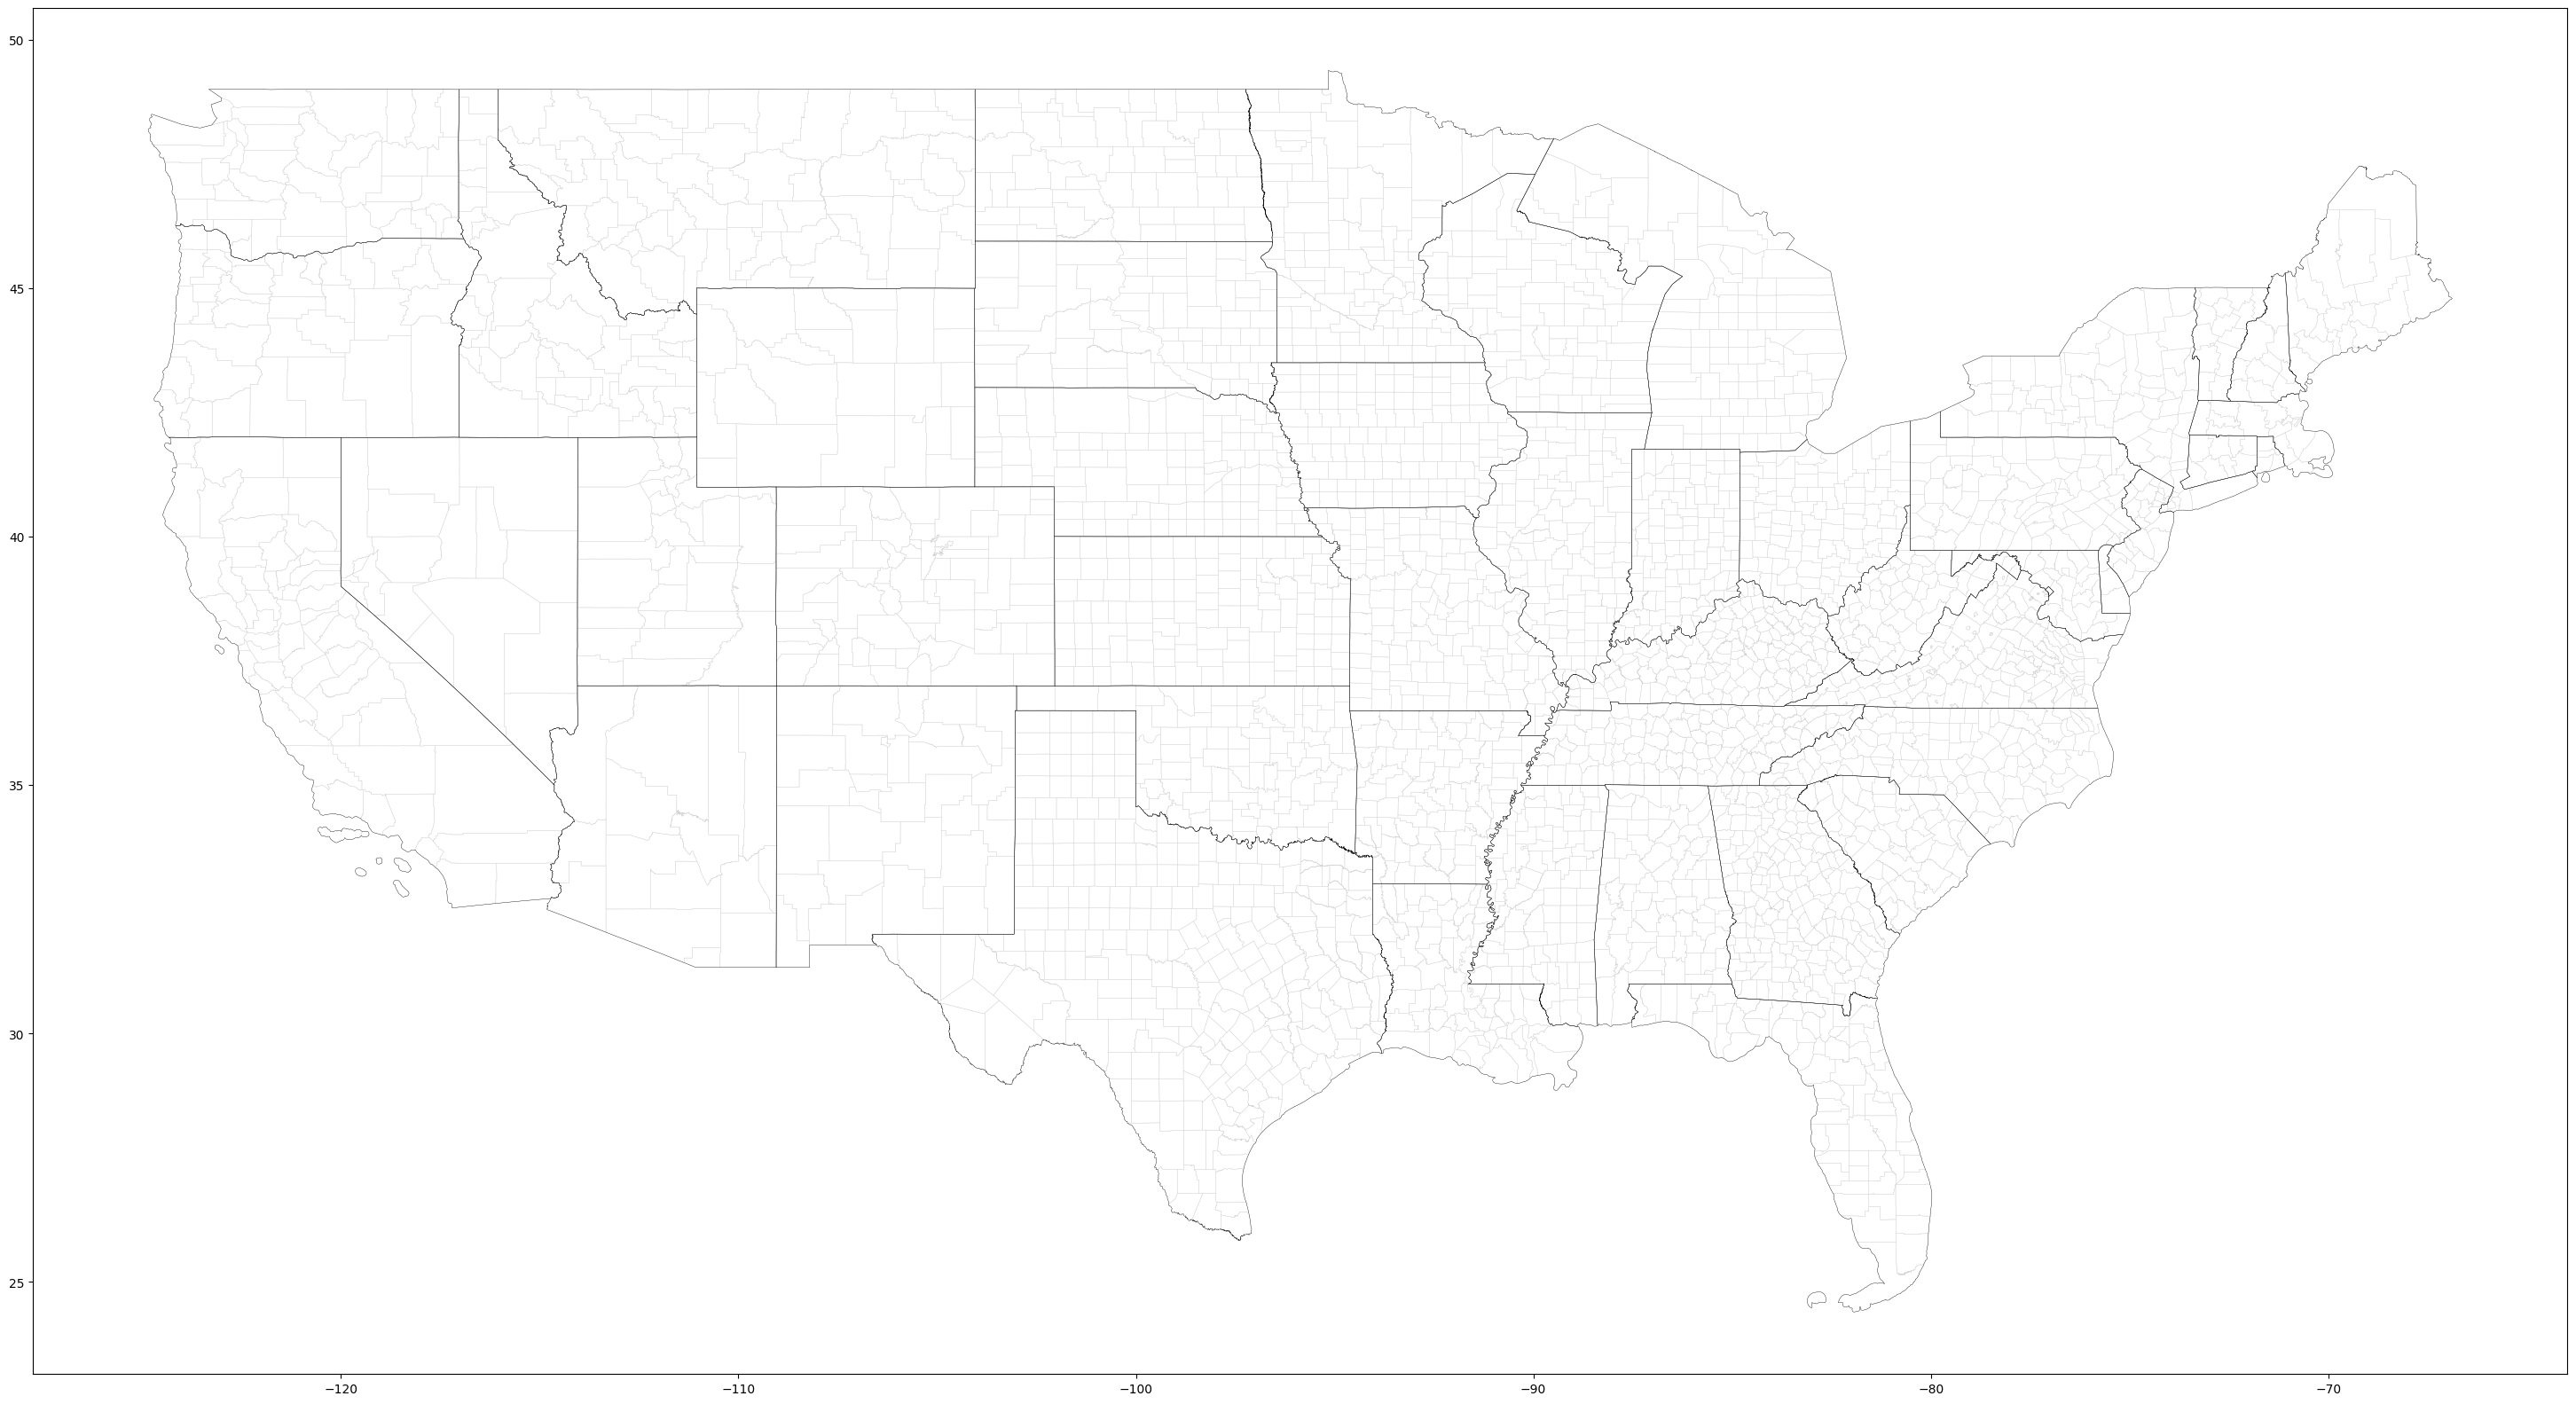

In [10]:
'''
Plot U.S. counties on map.
'''
%matplotlib inline

REGION = CONTINENTAL

# take only continental part of the U.S.
states_map = states[states["usps_abbr"].isin(REGION)]
counties_map = counties[counties["state_abbr"].isin(REGION)]

fig = plt.figure(0, figsize=(80,20)) 
plot = fig.add_subplot()

counties_map.boundary.plot(
    ax=plot, zorder=1,
    linewidth=0.25, color="lightgrey",
)

states_map.boundary.plot(
    ax=plot, zorder=1,
    linewidth=0.25, color="black",
)